In [1]:
import numpy as np
from msapy import msa, plottings as pl
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
import utils as ut
import pandas as pd
import netneurotools.datasets
from netneurotools.metrics import communicability_wei, communicability_bin
from netneurotools.plotting import plot_fsaverage
from scipy.stats import pearsonr
import warnings
from mayavi import mlab
from sklearn.preprocessing import StandardScaler

Qt: Session management error: None of the authentication protocols specified are supported


In [2]:
SEED = 2023
pl.set_style(font_size=8)
CM = 1/2.54

DEEP_BLUE = '#006685'
BLUE = '#3FA5C4'
WHITE = '#FFFFFF'
HALF_BLACK = '#232324'
ORANGE = '#E84653'
RED= '#BF003F'

PURPLE = '#A6587C'
PURPLER = '#591154'
PURPLEST = '#260126'
NIGHT_BLUE = '#394D73'
YELLOW = '#E6B213'


from_white = [DEEP_BLUE, BLUE, WHITE, ORANGE, RED]
white_to_reds = [WHITE, ORANGE, RED]
white_to_blues = [WHITE, BLUE, DEEP_BLUE]

black_to_reds = [HALF_BLACK, ORANGE, RED]
black_to_blues = [HALF_BLACK, BLUE, DEEP_BLUE]

from_black = [DEEP_BLUE,BLUE,HALF_BLACK,ORANGE,RED]



diverge_from_white = sns.blend_palette(from_white,as_cmap=True)
diverge_from_black = sns.blend_palette(from_black,as_cmap=True)

white_red_mono = sns.blend_palette(white_to_reds,as_cmap=True)
white_blue_mono = sns.blend_palette(white_to_blues,as_cmap=True)

black_red_mono = sns.blend_palette(black_to_reds,as_cmap=True)
black_blue_mono = sns.blend_palette(black_to_blues,as_cmap=True)

purple_red = sns.blend_palette([PURPLEST, PURPLE, RED])

In [3]:
human = netneurotools.datasets.fetch_connectome('human_struct_scale125')
human_fc = netneurotools.datasets.fetch_connectome('human_func_scale125')['conn']
np.fill_diagonal(human_fc,0)

In [4]:
connectivity = ut.spectral_normalization(1,human['conn'])
n_nodes = len(connectivity)


In [5]:
warnings.filterwarnings("ignore")

rng = np.random.default_rng(seed=SEED)
delta = 0.005
timesteps = int(500/delta)

noise_strength = 0.05
noise = rng.normal(0,noise_strength,(n_nodes,timesteps))
input = noise.copy()
simple_human_dynamics = ut.differntial_model(connectivity,input,delta=delta,G=0.9)

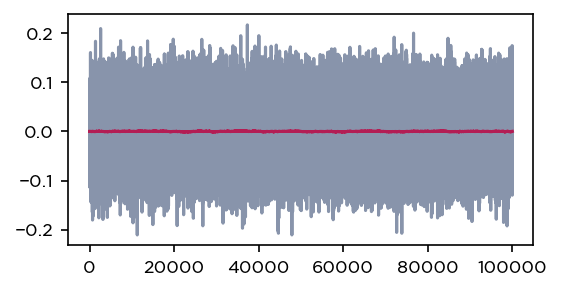

In [6]:
plt.figure(figsize=(4,2),dpi=150)
plt.plot(input[-1],alpha=0.6,color=NIGHT_BLUE)
plt.plot(simple_human_dynamics[-1],alpha=0.8,color=RED);

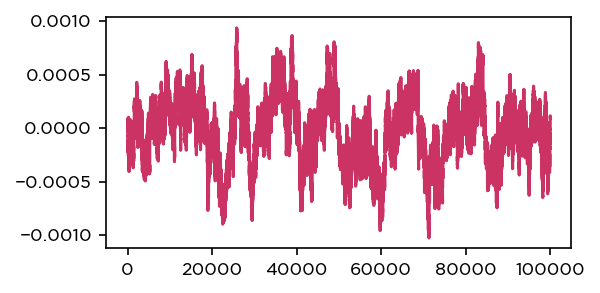

In [7]:
plt.figure(figsize=(4,2),dpi=150)
plt.plot(simple_human_dynamics[-1],alpha=0.8,color=RED);

In [8]:
fc = np.corrcoef(simple_human_dynamics)
np.fill_diagonal(fc,0)

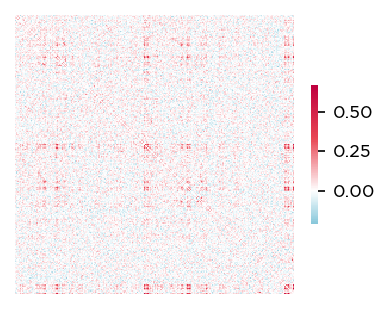

In [9]:
plt.figure(figsize=(3,3),dpi=150)
sns.heatmap(fc,square=True,center=0,cmap=diverge_from_white,cbar_kws={"shrink":.4},linewidths=0.,yticklabels=False,xticklabels=False);

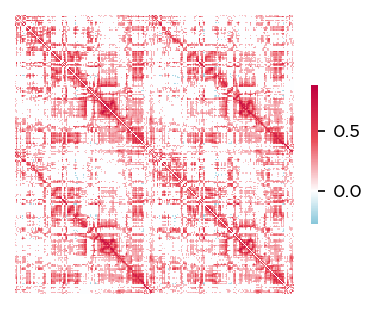

In [10]:
plt.figure(figsize=(3,3),dpi=150)
sns.heatmap(human_fc,square=True,center=0,cmap=diverge_from_white,cbar_kws={"shrink":.4},linewidths=0.,yticklabels=False,xticklabels=False);

In [11]:
n_samples = 10
dynamics = np.zeros((n_nodes,timesteps,n_samples))
fit_results = []

parameter_space = np.linspace(0.,1.,n_samples)

fcs = np.zeros((n_nodes,n_nodes,n_samples))
for index, coupling in enumerate(parameter_space):
    dynamics[:,:,index] = ut.differntial_model(connectivity,input,delta=delta,G=coupling)
    
    fcs[:,:,index] = np.corrcoef(dynamics[:,:,index])
    np.fill_diagonal(fcs[:,:,index],0)
    r,_= pearsonr(fcs[:,:,index].flatten(),human_fc.flatten())
    fit_results.append(r)


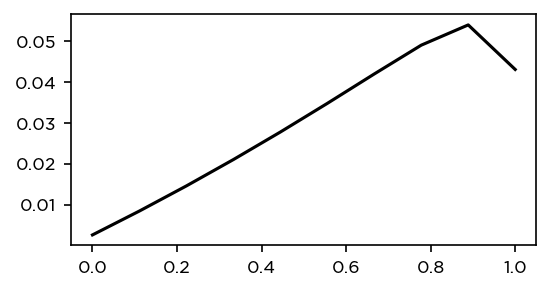

In [12]:
plt.figure(figsize=(4,2),dpi=150)
plt.plot(np.linspace(0,1,n_samples),fit_results,'k')


In [14]:
best_G = parameter_space[np.argmax(fit_results)]
best_fc = fcs[:,:,np.argmax(fit_results)]

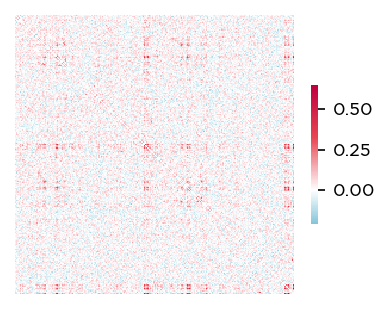

In [15]:
plt.figure(figsize=(3,3),dpi=150)
sns.heatmap(best_fc,square=True,center=0,cmap=diverge_from_white,cbar_kws={"shrink":.4},linewidths=0.,yticklabels=False,xticklabels=False);